In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
(train_set, valid_set), info = tfds.load('rock_paper_scissors',
                                         split=[tfds.Split.TRAIN, tfds.Split.TEST],
                                         with_info=True,
                                         as_supervised=True,
                                         shuffle_files=True)

n_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=1.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    urls=['http://laurencemoroney.com/rock-paper-scissors-dataset'],
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



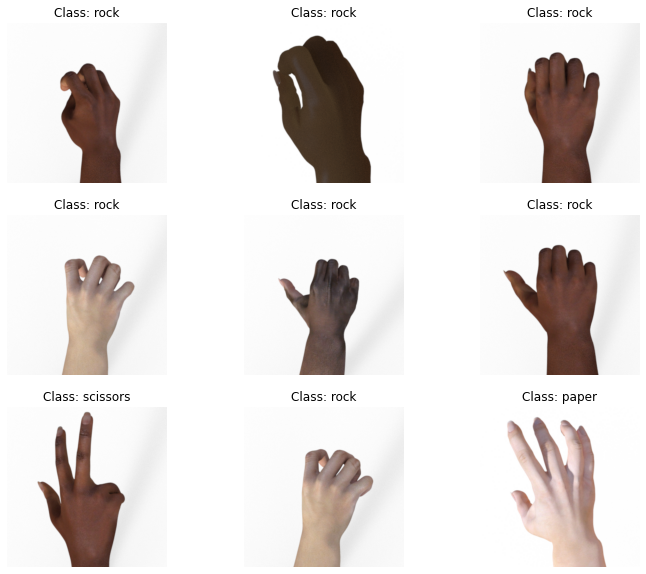

In [3]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [4]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

def augment_data(image, label):
    image = augment_flip(image)
    image = augment_rotation(image)
    image = augment_inversion(image)
    return image, label

train_set = train_set.map(augment_data)

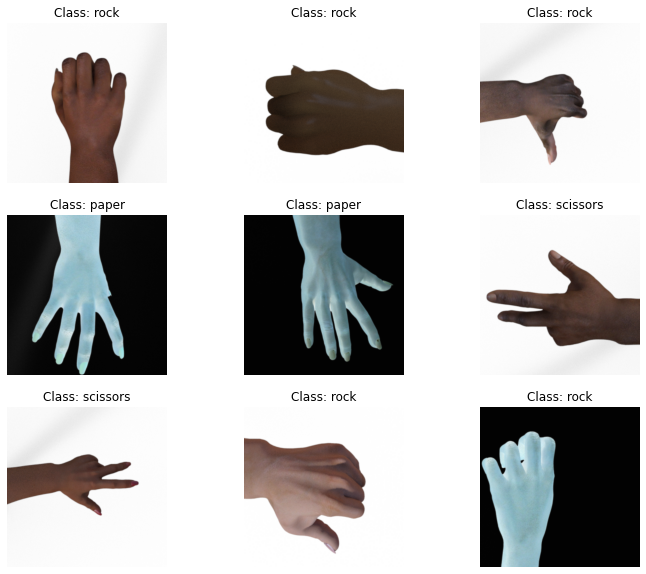

In [5]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [6]:
batch_size = 32

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)

In [7]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [8]:
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [9]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
79/79 [==============================] - 308s 4s/step - loss: 0.5090 - accuracy: 0.8091 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
79/79 [==============================] - 299s 4s/step - loss: 0.1735 - accuracy: 0.9365 - val_loss: 6.1140 - val_accuracy: 0.4167
Epoch 3/5
79/79 [==============================] - 298s 4s/step - loss: 0.1353 - accuracy: 0.9488 - val_loss: 5.7599 - val_accuracy: 0.4570
Epoch 4/5
79/79 [==============================] - 298s 4s/step - loss: 0.1145 - accuracy: 0.9567 - val_loss: 5.4285 - val_accuracy: 0.4247
Epoch 5/5
79/79 [==============================] - 297s 4s/step - loss: 0.1054 - accuracy: 0.9635 - val_loss: 4.6853 - val_accuracy: 0.4489


In [10]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, validation_data=valid_set, epochs=20)

Epoch 1/20
79/79 [==============================] - 655s 8s/step - loss: 0.1228 - accuracy: 0.9587 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
79/79 [==============================] - 641s 8s/step - loss: 0.0332 - accuracy: 0.9921 - val_loss: 0.5721 - val_accuracy: 0.8629
Epoch 3/20
79/79 [==============================] - 639s 8s/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0413 - val_accuracy: 0.9812
Epoch 4/20
79/79 [==============================] - 638s 8s/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.6223 - val_accuracy: 0.8441
Epoch 5/20
79/79 [==============================] - 645s 8s/step - loss: 9.4749e-04 - accuracy: 1.0000 - val_loss: 0.6269 - val_accuracy: 0.8495
Epoch 6/20
79/79 [==============================] - 639s 8s/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.5601 - val_accuracy: 0.8710
Epoch 7/20
79/79 [==============================] - 640s 8s/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.1615 - val_accuracy: 0.9194
E